## GP Solution

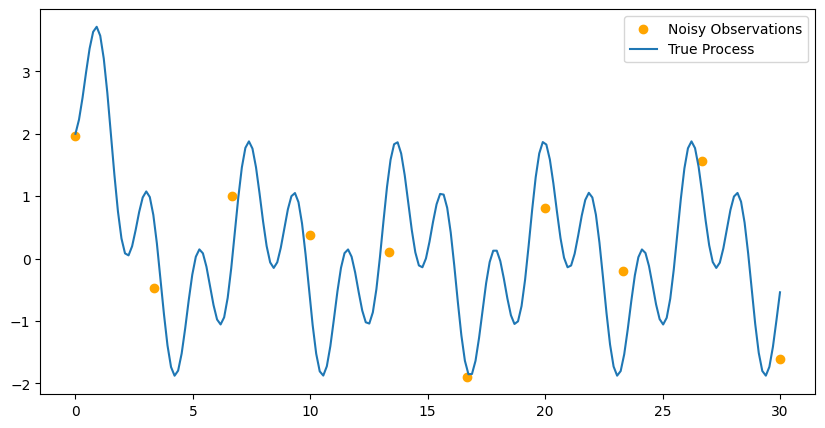

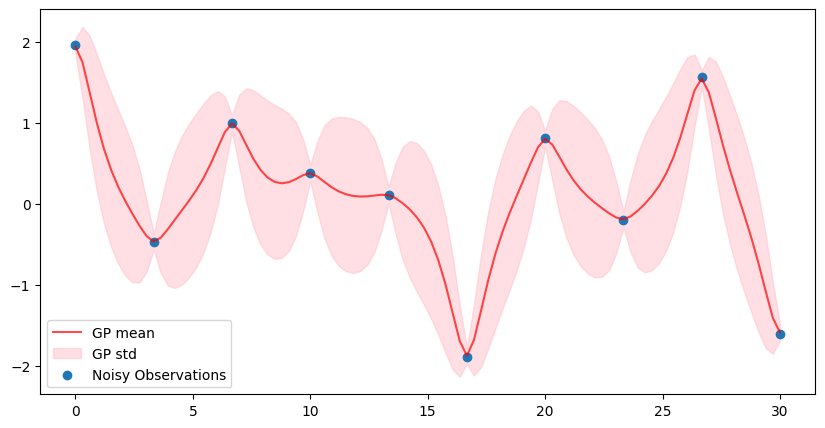

Time Taken:0.13157


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import time

np.random.seed(2)
n_steps = 200        #100
dt = 0.15            # 0.15
time_ = np.linspace(0, n_steps*dt, n_steps)
Total_time = n_steps * dt
N = 10 # number of random points - 30
M = 100 # number of test points - 100

sigma_2 = 0.1 ** 2

def process(t, sigma_2):
    noise = np.random.normal(0, np.sqrt(sigma_2), size=t.shape)
    y = np.sin(t) + 2*np.exp(-t**2/2) + np.exp(-t**3/2) - np.cos(3*t/2)
    return y+noise

y = np.sin(time_) + 2*np.exp(-time_**2/2) + np.exp(-time_**3/2) - np.cos(3*time_)

#to = np.random.choice(time_, size = N, replace = False).reshape(-1,1)
to = np.linspace(0, Total_time, N).reshape(-1,1)
to = np.sort(to)
yo = process(to, sigma_2)

# test points
t_test = np.linspace(0, n_steps*dt, M).reshape(-1,1)
tot2 = np.vstack([to, t_test])

plt.figure(figsize = (10,5))
plt.scatter(to, yo, label = 'Noisy Observations', color = 'orange')
plt.plot(time_, y, label = 'True Process')
plt.legend()
plt.show()


def matern32_kernel(X, Y, lengthscale=1.0, variance=1.0):

    distance = np.abs(X - Y.T)
    
    # Calculate the kernel matrix
    sqrt3 = np.sqrt(3.0)
    K = variance * (1.0 + sqrt3 * distance / lengthscale) * np.exp(-sqrt3 * distance / lengthscale)
    
    return K


def gp_regression(X1, X2, y1, kernel, noise = None):

    K11 = kernel(X1, X1)
    if noise is None:
        K11 += np.eye(K11.shape[0]) * 0.1**2
    K12 = kernel(X1, X2)
    K22 = kernel(X2, X2)


    L = scipy.linalg.cholesky(K11, lower = True)
    E = scipy.linalg.solve_triangular(L, K12, lower = True)
    v = scipy.linalg.solve_triangular(L, y1, lower = True)

    μ = E.T @ v
    Σ = K22 - E.T @ E

    return μ, Σ

start = time.time()
mu, var = gp_regression(X1 = to, X2 = t_test, y1 = yo, kernel = matern32_kernel)
end = time.time()


mu_gp = mu.flatten()
var_gp = np.diag(var).flatten()

plt.figure(figsize = (10,5))
plt.plot(t_test, mu_gp, 'r-', label = 'GP mean', alpha = 0.7)
plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'pink', alpha = 0.5, label = 'GP std')
plt.scatter(to, yo, label = 'Noisy Observations')
#plt.scatter(t_test, process(t_test, sigma_2), color = 'red')
plt.legend()
plt.show()

print ('Time Taken:{:.5f}'.format(end-start))

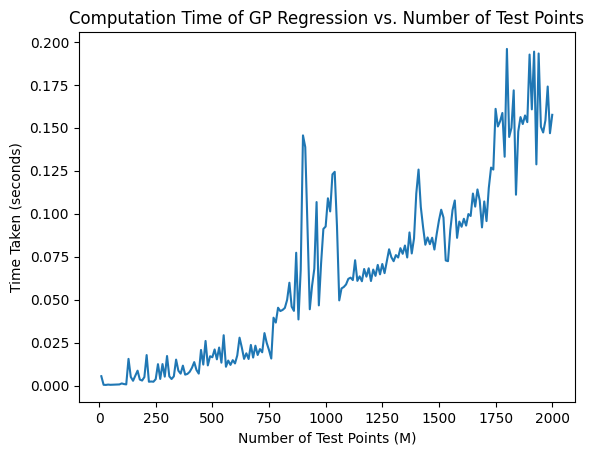

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import time

np.random.seed(2)
n_steps = 200
dt = 0.15
time_ = np.linspace(0, n_steps*dt, n_steps)
Total_time = n_steps * dt
N = 30 # number of train points (observed data)
#M = 100 # number of test points

sigma_2 = 0.1 ** 2

def process(t, sigma_2):
    noise = np.random.normal(0, np.sqrt(sigma_2), size=t.shape)
    y = np.sin(t) + 2*np.exp(-t**2/2) + np.exp(-t**3/2) - np.cos(3*t/2)
    return y+noise

def matern32_kernel(X, Y, lengthscale=1.0, variance=1.0):
    distance = np.abs(X - Y.T)
    sqrt3 = np.sqrt(3.0)
    K = variance * (1.0 + sqrt3 * distance / lengthscale) * np.exp(-sqrt3 * distance / lengthscale)
    return K

def gp_regression(X1, X2, y1, kernel, noise = None):
    K11 = kernel(X1, X1)
    if noise is None:
        K11 += np.eye(K11.shape[0]) * sigma_2
    K12 = kernel(X1, X2)
    K22 = kernel(X2, X2)

    L = scipy.linalg.cholesky(K11, lower = True)
    E = scipy.linalg.solve_triangular(L, K12, lower = True)
    v = scipy.linalg.solve_triangular(L, y1, lower = True)

    μ = E.T @ v
    Σ = K22 - E.T @ E

    return μ, Σ

# Define a range for the number of data points
M_range_GP = np.arange(10, 2010, 10) # Example range from 10 to 90 in steps of 10
times_GP = []

# Loop over the range
for M in M_range_GP:
    to = np.linspace(0, Total_time, N).reshape(-1,1)
    to = np.sort(to)
    yo = process(to, sigma_2)
    t_test = np.linspace(0, n_steps*dt, M).reshape(-1,1)

    start = time.time()
    mu, var = gp_regression(X1 = to, X2 = t_test, y1 = yo, kernel = matern32_kernel)
    end = time.time()

    times_GP.append(end - start)

# Plot the results
plt.plot(M_range_GP, times_GP)
plt.xlabel('Number of Test Points (M)')
plt.ylabel('Time Taken (seconds)')
plt.title('Computation Time of GP Regression vs. Number of Test Points')
plt.show()

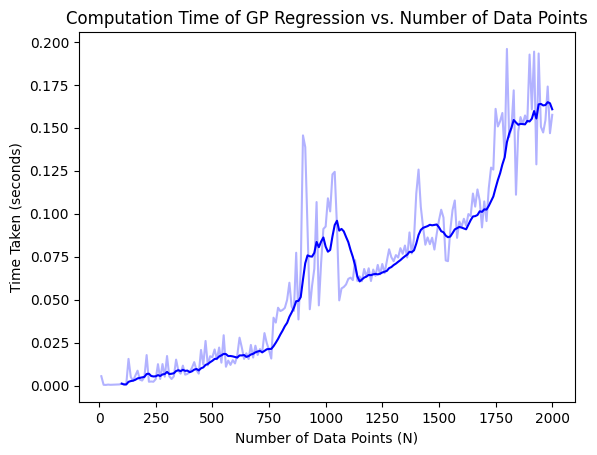

In [5]:
def moving_average(data, window_size):
    #return np.convolve(data, np.ones(window_size), 'valid') / window_size
    result = []
    moving_sum = sum(data[:window_size])
    result.append(moving_sum / window_size)

    for i in range(len(data) - window_size):
        moving_sum += (data[i + window_size] - data[i])
        result.append(moving_sum / window_size)

    return result


window_size = 10
moving_avg = moving_average(times_GP, window_size)

adjusted_N_range = M_range_GP[len(M_range_GP) - len(moving_avg):]

plt.plot(M_range_GP, times_GP, alpha = 0.3, color = 'blue')
plt.plot(adjusted_N_range, moving_avg, label = 'Moving Average', color = 'blue')
#plt.plot(N_range, moving_avg)
plt.xlabel('Number of Data Points (N)')
plt.ylabel('Time Taken (seconds)')
plt.title('Computation Time of GP Regression vs. Number of Data Points')
plt.show()

In [3]:
# Just merging observation time with test times 
# and sorting them to get the total time stamps TT
total_time = np.vstack([to, t_test])
indices = np.argsort(total_time.flatten(), axis = -1)
total_time = total_time[indices]
TT = total_time.shape[0]

In [4]:
doupdate = indices < N    # Perform state update on test points

ValueError: either both or neither of x and y should be given

In [5]:
# Define the LTI SDE model: Matern 3/2
ell = 1.0
lambda_ = np.sqrt(3) / ell
mag_sigma_2 = 1.0**2       # Magnitude of state covariance, can also tune this 
sigma_2 = 0.1 ** 2      # Observation noise

F = np.array([[0, 1], [-lambda_**2, -2 * lambda_]])
L = np.array([0, 1]).reshape(2,1)
Q = 4 * lambda_**3 * mag_sigma_2     # Process Noise
H = np.array([1, 0]).reshape(1,2)
Pinf = mag_sigma_2 * np.diag([1, lambda_**2])  # State Covariance


# Initialize
m = np.zeros((F.shape[0], 1))
P = copy.deepcopy(Pinf)

# Plae holders
MF = np.zeros((F.shape[0], TT))                # Updated Filter Mean
PF = np.zeros((F.shape[0], F.shape[1], TT))    # Updated Filter Covariance
MP = np.zeros((F.shape[0], TT))                # Predicted Filter Mean
PP = np.zeros((F.shape[0], F.shape[1], TT))    # Predicted Filter Covariance
GS = np.zeros((F.shape[0], F.shape[1], TT))    # Smoother Gain

start = time.time()
for k in range(0, TT):
    if k == 0:
        dt = 0
    else:
        dt = total_time[k] - total_time[k-1]
    
    # Solve the LTI Stochastic Differential Equation
    A = scipy.linalg.expm(F * dt)
    Q = Pinf - A @ Pinf @ A.T

    # kalman prediciton
    mp = A @ m
    Pp = A @ P @ A.T + Q

    # Pre-calculate smoother gain
    # Gs = (P @ A.T) @ np.linalg.inv(Pp)
    Gs = np.linalg.lstsq(Pp.T, (P @ A.T).T, rcond = None)[0].T

    # Kalman Update
    if doupdate[k]:
        v = (yo[indices[k]] - H @ mp).astype(np.float32)
        S = H @ Pp @ H.T + sigma_2                                                 # NOTE: Optimize
        #K = (Pp @ H.T)/S
        K = np.linalg.lstsq(S.T, (Pp @ H.T).T, rcond = None)[0].T
        m = mp + K * v
        P = Pp - K @ S @ K.T
    else:
        m = mp
        P = Pp

    MF[:, k] = m.T
    PF[:, :, k] = P
    MP[:, k] = mp.T
    PP[:, :, k] = Pp
    GS[:, :, k] = Gs

#end = time.time()

# Run RTS smoother
MS = copy.deepcopy(MF)
PS = copy.deepcopy(PF)
ms = MS[:, -1]
Ps = PS[:,:,-1]

for j in range(TT-2, -1, -1):
    ms = MF[:, j] + GS[:, :, j+1] @ (ms - MP[:, j+1])
    Ps = PF[:,:,j] + GS[:,:,j+1] @ (Ps - PP[:,:,j+1]) @ (GS[:,:,j+1]).T
    MS[:,j] = ms
    PS[:,:,j] = Ps

end = time.time()

# Extract Values
def get_var_f(index):
    var_f_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_f_.append( H @ PF[:,:,j] @ H.T )
    return np.array(var_f_)

def get_var_smooth(index):
    var_s_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_s_.append( H @ PS[:,:,j] @ H.T )
    return np.array(var_s_)

m_f = (H @ MF).T    # filter mean
m_s = (H @ MS).T    # smoother mean

print ('Time Taken: {:.5f}'.format(end-start))

Time Taken: 0.02561


In [9]:
MF[:,0]

array([1.93893485, 0.        ])

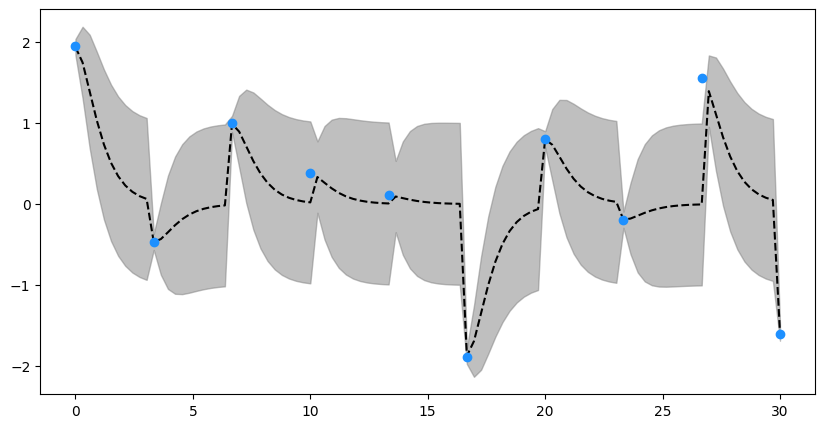

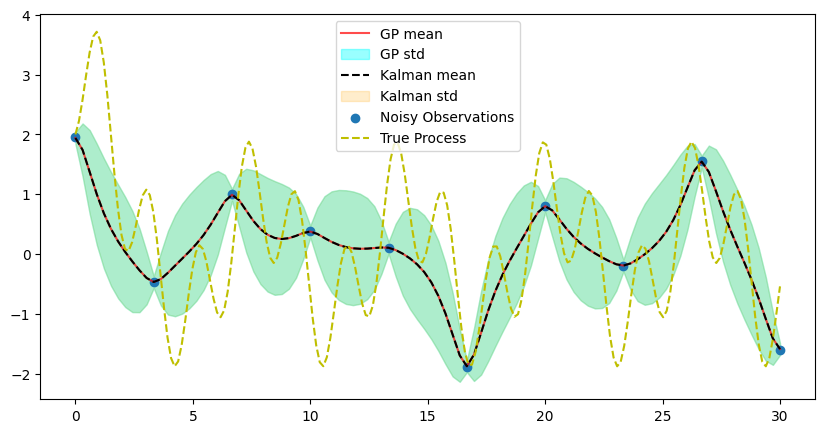

In [10]:
ii = [indices > N-1][0]
m_f = m_f[ii].flatten()
m_s = m_s[ii].flatten()
var_f = get_var_f(ii).flatten()
var_s = get_var_smooth(ii).flatten()

plt.figure(figsize = (10,5))
plt.plot(t_test, m_f, 'k--')
plt.plot(to, yo, 'o', color='dodgerblue')
plt.fill_between(t_test.flatten(), m_f-np.sqrt(var_f), \
                 m_f+np.sqrt(var_f), color='gray', alpha=0.5)

plt.show()


plt.figure(figsize = (10,5))
plt.plot(t_test, mu_gp, 'r-', label = 'GP mean', alpha = 0.7)
plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'aqua', alpha = 0.4, label = 'GP std')

plt.plot(t_test, m_s, 'k--', label = 'Kalman mean')
plt.fill_between(t_test.flatten(), m_s + np.sqrt(var_s), m_s - np.sqrt(var_s), color = 'orange', alpha = 0.2, label = 'Kalman std')
plt.scatter(to, yo, label = 'Noisy Observations')
plt.plot(time_, y, 'y--',label = 'True Process')
plt.legend()
plt.show()

In [7]:
import numpy as np
import scipy

A = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
print ('A:\n', A)
C = np.array([[0,1],[1,0]])

def obtain_inverse(A, A_inv, P, C, new_row_col):
    '''Get the inverse of updated kernel with 
    the oldest point removed and new point added'''

    new_size = A.shape[0]
    A_prime = np.zeros((new_size, new_size), dtype = A.dtype)

    # Copy the data from old matrix to new matrix except the first row and first column
    A_prime[:-1, :-1] = A[1:, 1:]

    # set the last column and last row to the new values
    A_prime[-1, :] = new_row_col
    A_prime[:, -1] = new_row_col

    mat = A_prime - P @ A @ P.T

    c = mat[:-1, -1:]
    d = mat[-1,-1]

    U = np.zeros(shape = (len(c)+1, 2))
    U[:-1,-1:] = c
    U[-1,-1] = d/2
    U[-1,0] = 1

    Q = P.T @ U

    # Woodbury Formula
    x = C + Q.T @ A_inv @ Q
    y = Q.T @ A_inv
    inverse_sol = np.linalg.lstsq(x, y, rcond = None)
    factor = A_inv - A_inv @ Q @ inverse_sol[0]
    A_prime_w_inv = P @ factor @ P.T

    return A_prime_w_inv

A:
 [[ 2 -1  0]
 [-1  2 -1]
 [ 0 -1  2]]


In [102]:
# Define Permutation matrix
P = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
A_inv = scipy.linalg.inv(A)
new_col_row = np.array([1, 0, 4])

obtain_inverse(A, A_inv, P, C, new_row_col=new_col_row)

array([[ 0.8,  0.4, -0.2],
       [ 0.4,  0.7, -0.1],
       [-0.2, -0.1,  0.3]])

In [ ]:
import numpy as np
import scipy

A = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 3]])
L = scipy.linalg.cholesky(A, lower = True)

print ('A:\n', A)    # Old A
print ('\nL:\n', L)  # Old Cholesky

# Two Step procedure
# 1. Add a new data point
A_aug = np.array([[2, -1, 0, 1], [-1, 2, -1, 0], [0, -1, 3, 1], [1, 0, 1, 3]])
print ('\nA_aug:\n', A_aug)

# Get new Cholesky for A_new
L_aug = np.zeros((4,4))
L_aug[:3, :3] = L

# Update off-diagonal elements in L
n = A_aug.shape[0]

for j in range(n-1):
    for i in range(j+1, n):
        sum_term = np.sum(L_aug[i, :j] * L_aug[j, :j])
        L_aug[i, j] = (A_aug[i, j] - sum_term) / L_aug[j, j]

# Update the diagonal element
sum_term = np.sum(L_aug[-1, :n-1] ** 2)
L_aug[-1, -1] = np.sqrt(A_aug[-1, -1] - sum_term)

print('\nL_aug:\n', L_aug)

# Get L's
L11 = L_aug[0][0]
Lo = L_aug[0,1:]
L1 = L_aug[1:,0].reshape(-1,1)
L2 = L_aug[1:,1:]

A2 = L2 @ L2.T
x = L1

A_prime = A2 + x @ x.T

print ('\nA_prime:\n', A_prime)

In [ ]:
import numpy as np
import scipy

# Algorithm  (17)
def cholupdate(L, x):
    n = x.shape[0] # If x is two-dimensional, we use its first dimension
    for k in range(n):
        # If x is a column vector (2D array), we convert it to a 1D array for calculations
        x_k = x[k, 0] if len(x.shape) > 1 else x[k]
        
        r = np.sqrt(L[k, k]**2 + x_k**2)
        c = r / L[k, k]
        s = x_k / L[k, k]
        L[k, k] = r
        if k < n - 1:
            # Perform the update on a 1D slice of L
            L_k_plus_1_n = L[(k+1):n, k]
            # Also ensure x[k+1:n] is treated as 1D for the update
            x_k_plus_1_n = x[(k+1):n].flatten()
            L[(k+1):n, k] = (L_k_plus_1_n + s * x_k_plus_1_n) / c
            # Update x considering its potential 2D structure
            x[(k+1):n] = (c * x_k_plus_1_n - s * L_k_plus_1_n).reshape(-1, 1)
    return L

cholupdate(L2, x)

In [ ]:
import numpy as np

def generate_permutation_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i, (i + 1) % n] = 1
    return matrix

generate_permutation_matrix(5)

### Online Learning with IHGP

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def get_dF(i, l):
    if i == 0 or i == 1:
        dF = np.zeros((2,2))
    elif i == 2:
        dF = np.array([[0, 0], [6/l**3, 2 * np.sqrt(3)/l**2]])
    return dF

def get_dA(i, l, dt):
    dF = get_dF(i, l)
    dA = scipy.linalg.expm(dF * dt)
    return dA

def get_dP_inf(i, sigma, l):
    if i == 0:
        dP_inf = np.zeros((2,2))
    elif i == 1:
        dP_inf = np.array([[1, 0],[0, 3/l**2]])
    elif i == 2:
        dP_inf = np.array([[0, 0], [0, -6*sigma/l**3]])
    return dP_inf

def get_dQ(i, sigma, l, dt, A, P_inf):
    dP_inf = get_dP_inf(i, sigma, l)
    dA = get_dA(i, l, dt)
    dQ = dP_inf - dA @ P_inf @ A - A.T @ dP_inf @ A - A.T @ P_inf @ dA
    return dQ


# Initialize MK -- filter conditional mean
#m_k_prev = np.zeros((2,1))

def optimize_hyper(initial_theta, Y_k, dt, eta, tolerance, max_iterations, m_k_prev):
    '''
    Args: 
        initial_theta: (shape: 3x1) hyperparmeters. [σ_n^2, σ^2, ℓ]
        Y_k: Window of latest w number of observations
        dt: t_{k} - t_{k-1}
        eta: learning rate
        tolerance: tolerance value to terminate optimization
        max_iterations: maximum iterations before terminating
        m_k_prev: previous filter conditional mean
    Returns:
        theta: updated theta
    '''
    sigma_n_2, sigma_2, l = initial_theta.reshape(-1)
    theta = np.abs(initial_theta)
    iteration = 0
    m = m_k_prev

    MF = np.zeros((2, len(Y_k)))
    PF = np.zeros((2,2, len(Y_k)))
    MP = np.zeros((2, len(Y_k)))
    PP = np.zeros((2,2, len(Y_k)))
    GS = np.zeros((2, 2, len(Y_k)))

    while True:

        F = np.array([[0.0, 1.0],[-3/(l**2), -2*np.sqrt(3)/np.abs(l)]])
        Qc = 12 * np.sqrt(3) * sigma_2 / l**3                                           
        C = np.array([1,0]).reshape(1,2)   
        P_inf = np.array([[(np.sqrt(np.abs(sigma_2))), 0.0], [0.0, 3 * (np.sqrt(np.abs(sigma_2)))/l**2]])   # Force sigma_2 to be positive

        # Solve LTI SDE 
        A = scipy.linalg.expm(F * dt)
        Q = P_inf - A @ P_inf @ np.transpose(A)

        #print ('\nP_inf: \n', P_inf)
        #print ('A: \n', A)
        #print ('Q: \n', Q)
        #norm = np.linalg.norm(Q - Q.conj().T,1)
        #spacing = np.spacing(np.linalg.norm(Q,1)) ** 100
        #print ('norm: ',norm)
        #print ('spacing: \n', spacing)
        
        R = sigma_n_2

        # Solve Discrete Algebriac Riccati Equation (DARE) to get P
        P_dare = scipy.linalg.solve_discrete_are(A, C.T, Q, R)
        P = P_inf
        
        for i, y_k in enumerate(Y_k):
            # Kalman Prediction
            mp = A @ m
            Pp = A @ P @ A.T + Q

            # Pre-calculate smoother Gain
            Gs = np.linalg.lstsq(Pp.T, (P @ A.T).T, rcond = None)[0].T

            # Kalman Update
            v = (y_k - C @ m).astype(np.float32)                      #TODO: Check if its mp or m
            S = C @ P @ C.T + R                                       #TODO: Check if its Pp or P
            K = np.linalg.lstsq(S.T, (P @ C.T).T, rcond = None)[0].T
            m += K * v
            P -= K @ C @ P

            MF[:, i] = m.T
            PF[:, :, i] = P
            MP[:, i] = mp.T
            PP[:, :, i] = Pp
            GS[:, :, i] = Gs

        # Run RTS smoother
        MS = copy.deepcopy(MF)
        PS = copy.deepcopy(PF)
        ms = MS[:, -1]
        Ps = PS[:,:,-1]

        for j in range(len(Y_k)-2, -1, -1):
            ms = MF[:, j] + GS[:, :, j+1] @ (ms - MP[:, j+1])
            Ps = PF[:,:,j] + GS[:,:,j+1] @ (Ps - PP[:,:,j+1]) @ (GS[:,:,j+1]).T
            MS[:,j] = ms
            PS[:,:,j] = Ps
        
            
        # Get 'm'
        m_ = MS
        
        # Get Likelihood and gradient from a different routine                     
        L, grad = gradient(A, C, P_dare, Y_k, theta, m_, dt)

        # Update theta
        new_theta = theta + eta * grad
        iteration += 1

        # Check for convergence
        if np.linalg.norm(new_theta - theta) <= tolerance or iteration >= max_iterations:
            break
        
        theta = np.abs(new_theta)
        sigma_n_2, sigma_2, l = theta.reshape(-1)

        #print ('theta:\n', theta)

    return theta
    

def gradient(A, C, P, Y, theta, m, dt):
    '''
    Compute the Likelihood and its gradient
    '''
    sigma_n_2, sigma_2, l = theta.reshape(-1,1)
    sigma_n_2 = sigma_n_2[0]
    sigma_2 = sigma_2[0]
    l = l[0]

    #P_inf = np.array([[np.sqrt(sigma_2), 0], [0, 3 * np.sqrt(sigma_2)/ l]])
    P_inf = np.array([[np.sqrt(np.abs(sigma_2)), 0.0], [0.0, 3 * np.sqrt(np.abs(sigma_2))/l**2]])
    R = sigma_n_2
    
    s_hat = C @ P @ C.T + R
    K = np.linalg.lstsq(s_hat.T, C @ P.T, rcond=None)[0].T
    dR = np.array([1.0, 0.0, 0.0]).reshape(-1,1)

    dS = []
    dK = []
    for i in range(3):
        dA = get_dA(i, l, dt)
        dQ = get_dQ(i, sigma = np.sqrt(np.abs(sigma_2)), l = l, dt = dt, A = A, P_inf = P_inf)

        s_hat_inv = np.linalg.lstsq(s_hat, C @ P @ A, rcond=None)[0]
        A_bar = A - C.T @ s_hat_inv


        Q_bar_i = A.T @ P @ C.T @ np.linalg.lstsq(s_hat, dR[i].reshape(-1,1), rcond = None)[0] @ s_hat_inv + dQ


        # Solve Discrete Lyapunov
        #P'_i = dlyap(A_bar.T , Q_bar_i)

        P_prime = scipy.linalg.solve_discrete_lyapunov(A_bar.T, Q_bar_i)

        assert P_prime.shape == A.shape, 'Shape of A and B are not the same'

        dSi = C @ P_prime @ C.T + dR[i].reshape(-1,1)
        dKi = P_prime @ C.T / s_hat[0][0] - P @ C.T @ dSi / (s_hat[0][0])**2

        dS.append(dSi)
        dK.append(dKi)

    dS = np.array(dS)
    dK = np.array(dK)

    dS = dS.reshape(-1,1)

    N = len(Y)
    L = N/2 * np.log(2 * np.pi) + N/2 * np.log(s_hat[0][0])
    grad = N/2 * dS / s_hat[0][0]
    

    dm = np.zeros((3,2,1)) # place holder for dm vector
    for i, yi in enumerate(Y):
        mi = m[:,i].reshape(-1,1)       # Shape = (2,1)
        assert mi.shape == (2,1), 'mi shape needs to be (2,1)'
        v = yi - (C @ A @ mi)[0][0]        # scalar
        L += 0.5* v**2/s_hat[0][0]         # scalar

        dv0 = -C @ get_dA(0, l, dt) @ mi - C @ A @ dm[0]
        dv1 = -C @ get_dA(1, l, dt) @ mi - C @ A @ dm[1]
        dv2 = -C @ get_dA(2, l, dt) @ mi - C @ A @ dm[2]

        dv = np.array([dv0, dv1, dv2]).reshape(-1,1)

        dm[0] = A @ K @ C @ A @ dm[0] + dK[0] @ np.array(yi).reshape(-1,1)
        assert dm[0].shape == (2,1), 'dm[0] shape must be (2,1)'
        dm[1] = A @ K @ C @ A @ dm[1] + dK[1] @ np.array(yi).reshape(-1,1)
        dm[2] = A @ K @ C @ A @ dm[2] + dK[2] @ np.array(yi).reshape(-1,1)


        grad += v * dv /s_hat[0][0] - 0.5 * v**2 * dS.reshape(-1,1) / s_hat[0][0]**2

        #print ('Likelihood: {},\nGradient:\n{}\n'.format(L, grad))

    return L, grad    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import time

np.random.seed(2)
n_steps = 200        #100
dt = 0.15            # 0.15
time_ = np.linspace(0, n_steps*dt, n_steps)
Total_time = n_steps * dt
N = 30 # number of random points
M = 100 # number of test points

sigma_2 = 0.1 ** 2

def process(t, sigma_2):
    noise = np.random.normal(0, np.sqrt(sigma_2), size=t.shape)
    y = np.sin(t) + 2*np.exp(-t**2/2) + np.exp(-t**3/2) - np.cos(3*t/2)
    return y+noise

y = np.sin(time_) + 2*np.exp(-time_**2/2) + np.exp(-time_**3/2) - np.cos(3*time_)

#to = np.random.choice(time_, size = N, replace = False).reshape(-1,1)
to = np.linspace(0, Total_time, N).reshape(-1,1)
to = np.sort(to)
yo = process(to, sigma_2)

# test points
t_test = np.linspace(0, n_steps*dt, M).reshape(-1,1)



# Just merging observation time with test times 
# and sorting them to get the total time stamps TT
total_time = np.vstack([to, t_test])
indices = np.argsort(total_time.flatten(), axis = -1)
total_time = total_time[indices]
TT = total_time.shape[0]


doupdate = indices < N 

In [2]:
def matern32_kernel(X, Y, lengthscale=1.0, variance=1.0):

    distance = np.abs(X - Y.T)
    
    # Calculate the kernel matrix
    sqrt3 = np.sqrt(3.0)
    K = variance * (1.0 + sqrt3 * distance / lengthscale) * np.exp(-sqrt3 * distance / lengthscale)
    
    return K


def gp_regression(X1, X2, y1, kernel, ell, mag_sigma_2, noise = None):

    K11 = kernel(X1, X1, ell, mag_sigma_2)
    if noise is None:
        K11 += np.eye(K11.shape[0]) * 0.1**2
    else:
        K11 += np.eye(K11.shape[0]) * noise
    K12 = kernel(X1, X2)
    K22 = kernel(X2, X2)


    L = scipy.linalg.cholesky(K11, lower = True)
    E = scipy.linalg.solve_triangular(L, K12, lower = True)
    v = scipy.linalg.solve_triangular(L, y1, lower = True)

    μ = E.T @ v
    Σ = K22 - E.T @ E

    return μ, Σ


def kalman_filter(A, m, P, Q, k, yo, H):
    # kalman prediction 
    mp = A @ m
    Pp = A @ P @ A.T + Q

    # Pre-calculate smoother gain
    Gs = np.linalg.lstsq(np.transpose(Pp), np.transpose((P @ np.transpose(A))), rcond = None)[0]
    Gs = np.transpose(Gs)

    # kalman Update
    if doupdate[k]:
        v = (yo[indices[k]] - H @ mp).astype(np.float32)
        S = H @ Pp @ H.T + sigma_2                                                
        #K = (Pp @ H.T)/S
        K = np.linalg.lstsq(S.T, (Pp @ H.T).T, rcond = None)[0].T
        m = mp + K * v
        P = Pp - K @ S @ K.T
    else:
        m = mp
        P = Pp

    return m, P, mp, Pp, Gs

In [3]:
from utils import *

In [4]:
# Define Matrices
def get_F(l):
    return np.array([[0.0, 1.0], [-3/l**2, -2 * np.sqrt(3)/l]])

def get_Pinf(sigma2, l):
    return np.diag([sigma2, 3*sigma2/l**2])


# Define the LTI SDE model: Matern 3/2
ell = 1.0
lambda_ = np.sqrt(3) / ell
mag_sigma_2 = 1.0**2       # Magnitude of state covariance, can also tune this 
sigma_2 = 0.1 ** 2         # Observation noise

theta = np.array([sigma_2, mag_sigma_2, ell]).reshape(-1,1)

F0 = np.array([[0, 1], [-lambda_**2, -2 * lambda_]])
L = np.array([0, 1]).reshape(2,1)
Q = 4 * lambda_**3 * mag_sigma_2     # Process Noise
H = np.array([1, 0]).reshape(1,2)
Pinf0 = mag_sigma_2 * np.diag([1, lambda_**2])  # State Covariance


# Initialize
m = np.zeros((F0.shape[0], 1))
P = copy.deepcopy(Pinf0)

# Place holders
MF = np.zeros((F0.shape[0], TT))                # Updated Filter Mean
PF = np.zeros((F0.shape[0], F0.shape[1], TT))   # Updated Filter Covariance
MP = np.zeros((F0.shape[0], TT))                # Predicted Filter Mean
PP = np.zeros((F0.shape[0], F0.shape[1], TT))   # Predicted Filter Covariance
GS = np.zeros((F0.shape[0], F0.shape[1], TT))   # Smoother Gain
GPM = np.zeros((1, TT))                         # GP Mean
#GPV = np.zeros()


# Specify the window size and initialze observations inside the window
w = 5
Y_k = []
X_k = []  # states for MCMC
T_k = []

mu_G = []
var_G = []
t_infer = []

IHGP_thetas = []

window_updated = False # Flag to track if the observation window has been updated
#bounds = [(1e-5, None), (1e-5, None), (1e-5, None)]  # bounds for scipy optimization
bounds = [(1e-2, 1.0), (1e-2, 5.0), (1e-2, 5.0)]

start = time.time()
for k in range(0, TT-1):
    if k == 0:
        dt = 0
    else:
        dt = total_time[k] - total_time[k-1]

    #if k <= 19:
    #    Y_k.append(yo[k])
    #if len(Y_k) > w:
    #    Y_k.pop(0)

    if doupdate[k]:
        Y_k.append(yo[indices[k]])
        T_k.append(to[indices[k]])
        X_k.append(m)
        window_updated = True

    if len(Y_k) > w:
        Y_k.pop(0)
        T_k.pop(0)
        X_k.pop(0)
        window_updated = True

    if len(Y_k) == w and window_updated:
        '''1. Optimize via modified IHGP'''
        #theta = optimize_hyper(initial_theta = theta, Y_k = np.array(Y_k), dt = dt, eta = 1e-2, tolerance = 1e-3, max_iterations = 5, m_k_prev = np.zeros((2,1)))
        #sigma_2, mag_sigma_2 , ell = theta.reshape(-1)       # obs_noise, state_noise, length_scale
        

        #IHGP_thetas.append(theta)



        '''2. optimize theta via MCMC'''
        #print (f'Running MCMC')
        '''samples = metropolis_hasting(target_density = nll, 
                                     proposal_density = lognormal, 
                                     proposal_sampler = proposal_sampler,
                                     num_samples = 10,
                                     initial_state = np.array([ell, mag_sigma_2]),
                                     x = X_k,
                                     L = L,
                                     Q = Q,
                                     burn_in = 5,
                                     dt = dt)
        
        samples = np.array(samples)

        ell_mu = np.mean(samples[:,0])
        ell_std = np.std(samples[:,0]) 
        ell = np.random.normal(loc = ell_mu, scale = ell_std)

        sigma_mu = np.mean(samples[:,1])
        sigma_std = np.std(samples[:,1]) 
        mag_sigma_2 = np.random.normal(loc = sigma_mu, scale = sigma_std)'''

        #params = np.array([[ell_mu, sigma_mu],[ell_std, sigma_std]])

        #MCMC_thetas.append(params)'''



        '''3. Use GP solution -- Not working'''
        '''X1 = np.array(np.array(T_k).reshape(-1,1))
        X2 = np.linspace(T_k[0], T_k[1], 100)
        
        updated_kernel = lambda X1, X2, ell=ell, mag_sigma_2=mag_sigma_2: matern32_kernel(X1, X2, ell, mag_sigma_2)
        mu, var = gp_regression(X1 = X1,
                                X2 = X2,
                                y1 = np.array(Y_k).reshape(-1,1),
                                kernel = updated_kernel,
                                ell = ell,
                                mag_sigma_2 = mag_sigma_2,
                                noise = sigma_2)
        mu_G.append(mu.flatten())
        var_G.append(np.diag(var).flatten())
        
        t_infer.append(X2)'''


        '''4. Optimize via negative log-marginal likelihood from GP'''
        '''theta = scipy.optimize.minimize(neg_log_like, 
                                        np.array([sigma_2, mag_sigma_2, ell]), 
                                        args = (np.array(T_k),np.array(Y_k)), 
                                        method = 'L-BFGS-B', 
                                        jac = False, 
                                        bounds = bounds,
                                        options = {'maxiter':5})
        sigma_2, mag_sigma_2, ell = theta.x
        print (theta.x)'''



        '''5. optimize theta via MCMC'''
        #print (f'Running MCMC')
        '''samples = metropolis_hastingII(target_density = unnormalized_posterior, 
                                     proposal_density = lognormalII, 
                                     proposal_sampler = proposal_samplerII,
                                     num_samples = 10,
                                     initial_state = np.array([sigma_2,mag_sigma_2, ell]),
                                     x = np.array(T_k),
                                     y = np.array(Y_k),
                                     burn_in = 5)
        
        samples = np.array(samples)

        ell_mu = np.mean(samples[:,0])
        ell_std = np.std(samples[:,0]) 
        ell = np.random.normal(loc = ell_mu, scale = ell_std)

        sigma_mu = np.mean(samples[:,1])
        sigma_std = np.std(samples[:,1]) 
        mag_sigma_2 = np.random.normal(loc = sigma_mu, scale = sigma_std)'''


        '''6. Optimize via MAP estimate of GP'''
        theta = scipy.optimize.minimize(MAP, 
                                        np.array([sigma_2, mag_sigma_2, ell]), 
                                        args = (np.array(T_k),np.array(Y_k)), 
                                        method = 'L-BFGS-B', 
                                        jac = False, 
                                        bounds = bounds,
                                        options = {'maxiter':5})
        sigma_2, mag_sigma_2, ell = theta.x
        print (theta.x)



        window_updated = False     # Reset the Flag after optimization
        
    
    # Solve the LTI Stochastic Differential Equation
    F = get_F(l = ell)
    A = scipy.linalg.expm(F * dt)
    Pinf = get_Pinf(mag_sigma_2, ell)
    Q = Pinf - A @ Pinf @ A.T

    # Get solution using Kalman Filter
    m, P, mp, Pp, Gs = kalman_filter(A, m, P, Q, k, yo, H)
    MF[:, k] = m.T
    PF[:, :, k] = P
    MP[:, k] = mp.T
    PP[:, :, k] = Pp
    GS[:, :, k] = Gs



# Run RTS smoother
MS = copy.deepcopy(MF)
PS = copy.deepcopy(PF)
ms = MS[:, -1]
Ps = PS[:,:,-1]

for j in range(TT-2, -1, -1):
    ms = MF[:, j] + GS[:, :, j+1] @ (ms - MP[:, j+1])
    Ps = PF[:,:,j] + GS[:,:,j+1] @ (Ps - PP[:,:,j+1]) @ (GS[:,:,j+1]).T
    MS[:,j] = ms
    PS[:,:,j] = Ps

end = time.time()


# Extract Values
def get_var_f(index):
    var_f_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_f_.append( H @ PF[:,:,j] @ H.T )
    return np.array(var_f_)

def get_var_smooth(index):
    var_s_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_s_.append( H @ PS[:,:,j] @ H.T )
    return np.array(var_s_)

m_f = (H @ MF).T    # filter mean
m_s = (H @ MS).T    # smoother mean

print ('Time Taken: {:.5f}'.format(end-start))

[0.09685997 1.48763879 1.22723869]
[0.09993734 2.11698734 1.46831783]
[0.09999601 2.07771146 0.92695976]
[0.10001223 1.42604418 0.9448578 ]
[0.09990932 1.29429946 1.2373436 ]
[0.09998729 0.48331874 0.32022642]
[0.10129301 0.20034632 0.69488303]
[0.10033415 0.10707439 0.31010384]
[0.10060535 0.20431094 0.32392904]
[0.09995773 0.26043538 0.32821552]
[0.10483349 0.6995489  0.40183977]
[0.0997378  1.07745909 0.83854002]
[0.09999577 1.46984857 0.71372045]
[0.09997536 1.42433551 0.98681591]
[0.0999698  1.58884649 0.97519022]
[0.09998155 1.23347946 1.00073845]
[0.09987904 1.08275609 1.27469459]
[0.0999872  0.51295291 0.4909888 ]
[0.10018252 0.21945837 1.00189629]
[0.10011972 0.32825833 0.93921068]
[0.10035808 0.32633867 1.2338915 ]
[0.09997008 0.46863864 1.05731888]
[0.09992296 0.93149131 0.96300259]
[0.09994039 1.02199311 1.0641252 ]
[0.0999973  1.47241316 0.75368729]
[0.09996392 1.47277658 1.0512481 ]
Time Taken: 0.22871


In [5]:
params = np.array([1.0, 2.0, 3.0])
prior_means = np.array([0.01, 1.0, 1.0])
prior_sigmas = np.array([0.001, 2, 2])
neg_log_prior = 0.5 * np.sum(((params - prior_means) / prior_sigmas) ** 2)
neg_log_prior

490050.625

In [107]:
IHGP_thetas = np.array(IHGP_thetas)

In [11]:
MCMC_thetas = np.array(MCMC_thetas)


In [13]:
np.save('IHGP_thetas.npy', IHGP_thetas)

In [6]:
ii = [indices > N-1][0]
m_f = m_f[ii].flatten()
m_s = m_s[ii].flatten()
var_f = get_var_f(ii).flatten()
var_s = get_var_smooth(ii).flatten()

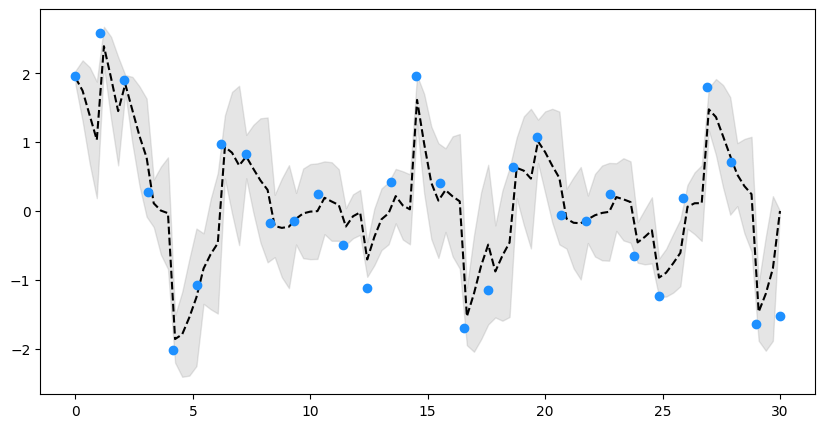

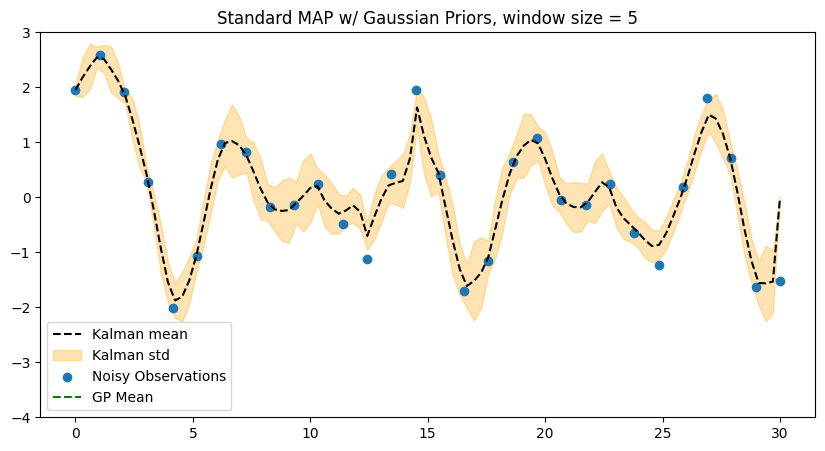

In [7]:
plt.figure(figsize = (10,5))
plt.plot(t_test, m_f, 'k--')
plt.plot(to, yo, 'o', color='dodgerblue')
plt.fill_between(t_test.flatten(), m_f-np.sqrt(var_f), \
                 m_f+np.sqrt(var_f), color='gray', alpha=0.2)

plt.show()

plt.figure(figsize = (10,5))
#plt.plot(t_test, mu_gp, 'r-', label = 'Batch - GP mean', alpha = 0.9)
#plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'aqua', alpha = 0.9, label = 'Batch - GP std')

plt.title('Standard MAP w/ Gaussian Priors, window size = {}'.format(w))
plt.plot(t_test, m_s, 'k--', label = 'Kalman mean')
plt.fill_between(t_test.flatten(), m_s + np.sqrt(var_s), m_s - np.sqrt(var_s), color = 'orange', alpha = 0.3, label = 'Kalman std')
plt.scatter(to, yo, label = 'Noisy Observations')
#plt.plot(time_, y, 'y--',label = 'True Process')

t_infer = np.array(t_infer)
mu_G = np.array(mu_G)
plt.plot(t_infer.reshape(-1), mu_G.reshape(-1), 'g--', label = 'GP Mean')
plt.ylim([-4,3])


plt.legend()
plt.show()

## Optimize via MCMC

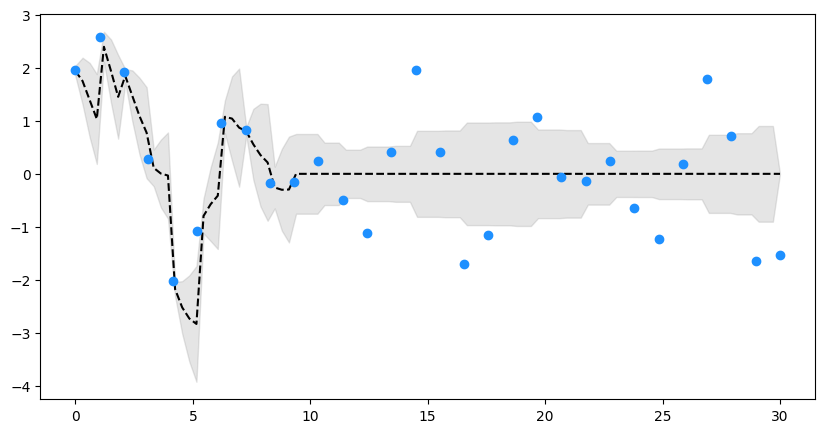

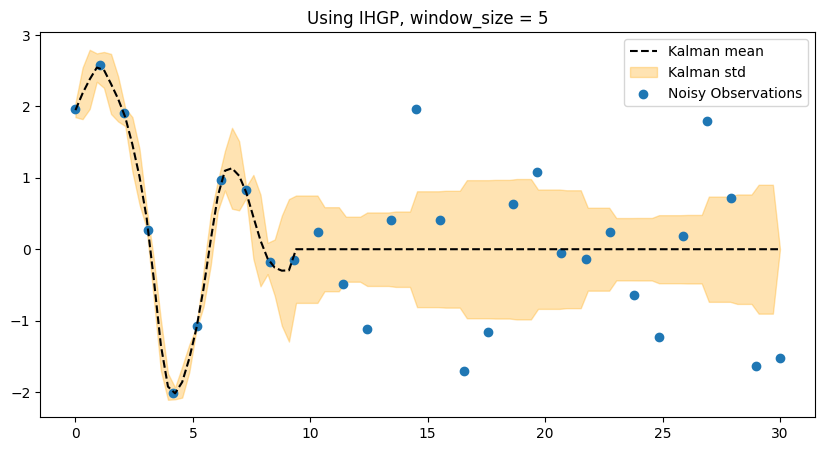

In [19]:
plt.figure(figsize = (10,5))
plt.plot(t_test, m_f, 'k--')
plt.plot(to, yo, 'o', color='dodgerblue')
plt.fill_between(t_test.flatten(), m_f-np.sqrt(var_f), \
                 m_f+np.sqrt(var_f), color='gray', alpha=0.2)

plt.show()

plt.figure(figsize = (10,5))
#plt.plot(t_test, mu_gp, 'r-', label = 'Batch - GP mean', alpha = 0.9)
#plt.fill_between(t_test.flatten(), mu_gp + np.sqrt(var_gp), mu_gp - np.sqrt(var_gp), color = 'aqua', alpha = 0.9, label = 'Batch - GP std')

plt.title('Using IHGP, window_size = 5')
plt.plot(t_test, m_s, 'k--', label = 'Kalman mean')
plt.fill_between(t_test.flatten(), m_s + np.sqrt(var_s), m_s - np.sqrt(var_s), color = 'orange', alpha = 0.3, label = 'Kalman std')
plt.scatter(to, yo, label = 'Noisy Observations')
#plt.plot(time_, y, 'y--',label = 'True Process')


plt.legend()
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
IHGP = np.load('IHGP_thetas.npy')
MCMC = np.load('MCMC_thetas.npy')
#NMLL = np.load('NMLL_thetas.npy')


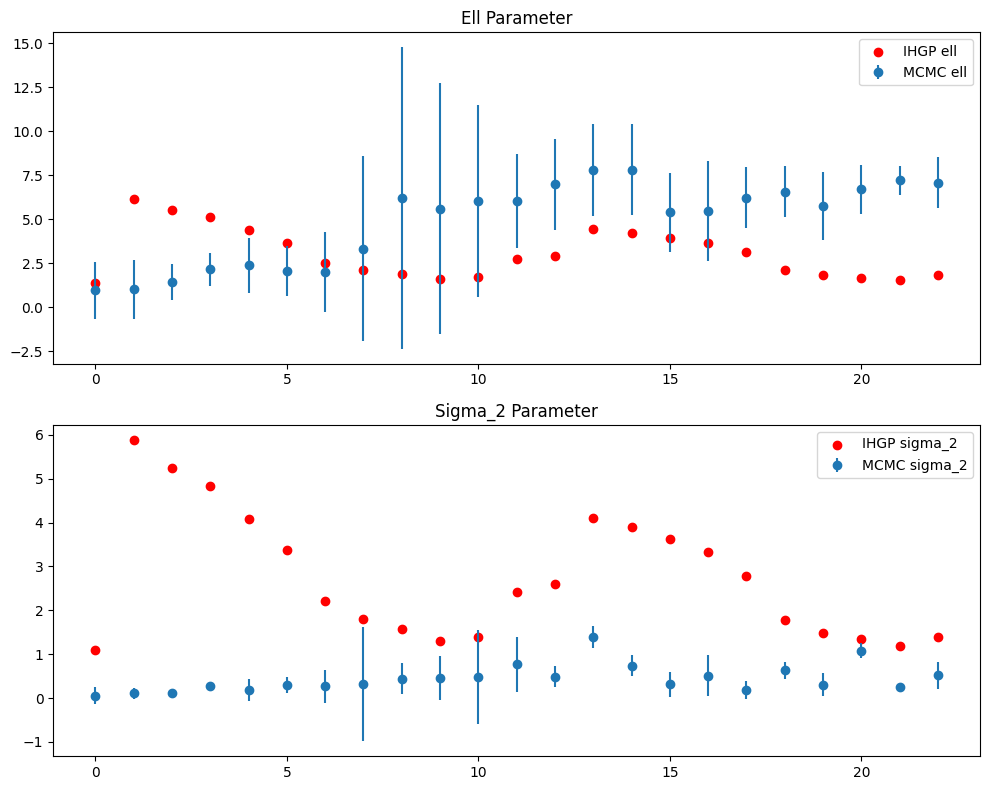

In [37]:
# Extract data
ell_ihgp = IHGP[:-3, 1, 0]  # Second element of IHGP vectors
sigma_2_ihgp = IHGP[:-3, 2, 0]  # Third element of IHGP vectors

ell_mcmc_mean = MCMC[:-3, 0, 0]
sigma_2_mcmc_mean = MCMC[:-3, 1, 0]
ell_mcmc_std = MCMC[:-3, 0, 1]
sigma_2_mcmc_std = MCMC[:-3, 1, 1]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ell
ax[0].errorbar(range(len(ell_mcmc_mean)), ell_mcmc_mean, yerr=ell_mcmc_std, fmt='o', label='MCMC ell')
ax[0].scatter(range(len(ell_ihgp)), ell_ihgp, color='red', label='IHGP ell')
ax[0].set_title('Ell Parameter')
ax[0].legend()

# sigma_2
ax[1].errorbar(range(len(sigma_2_mcmc_mean)), sigma_2_mcmc_mean, yerr=sigma_2_mcmc_std, fmt='o', label='MCMC sigma_2')
ax[1].scatter(range(len(sigma_2_ihgp)), sigma_2_ihgp, color='red', label='IHGP sigma_2')
ax[1].set_title('Sigma_2 Parameter')
ax[1].legend()
plt.tight_layout()
plt.show()

In [34]:
z = np.array([1,2,3,4,5])
z[:-2]

array([1, 2, 3])

### Working with Gradients

In [56]:
x = to
y = yo

In [14]:
y.shape

(30, 1)

In [74]:

import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'C':20, 'C++':15, 'Java':30, 
        'Python':35}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

array([ 4.18976096, -3.04264283, -2.95862396])

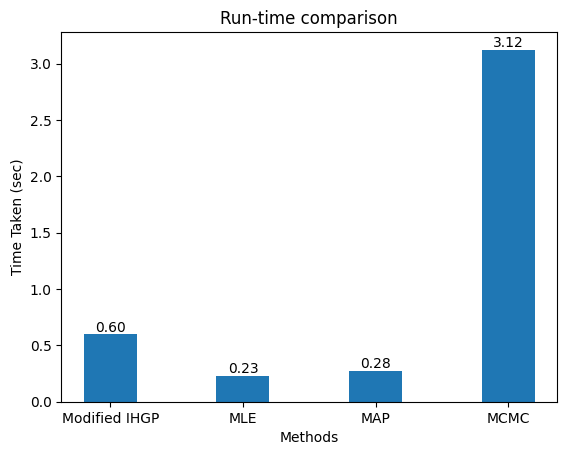

In [28]:
#data = np.array([0.59720, 0.22697, 0.27556, 3.12230, 62.08079])
data = {'Modified IHGP': 0.59720, 'MLE': 0.22697, 'MAP': 0.27556, 'MCMC': 3.12230, 'MCMC From I': 62.08079}
times = list(data.values())
method = list(data.keys())

plt.bar(method[:-1], times[:-1], width = 0.4)

for i in range(len(times)-1):
    plt.text(i, times[i], f'{times[i]:.2f}', ha='center', va='bottom')
    
plt.xlabel('Methods')
plt.ylabel('Time Taken (sec)')
plt.title('Run-time comparison')
plt.show()

In [12]:
x = np.array([1,2,3])
x[:-1]

array([1, 2])

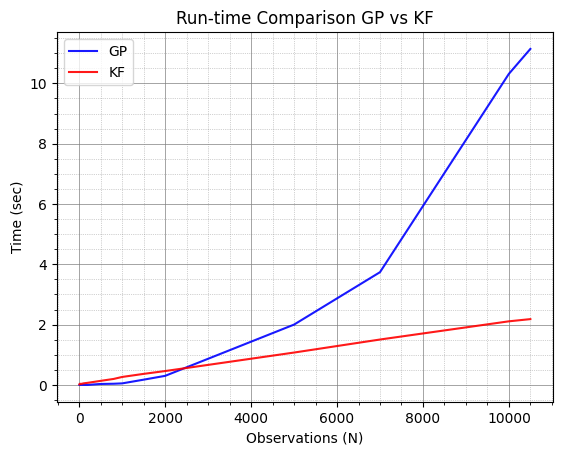

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    #return np.convolve(data, np.ones(window_size), 'valid') / window_size
    result = []
    moving_sum = sum(data[:window_size])
    result.append(moving_sum / window_size)

    for i in range(len(data) - window_size):
        moving_sum += (data[i + window_size] - data[i])
        result.append(moving_sum / window_size)

    return result


window_size = 2

GP = np.array([0.001931, 0.001520, 0.003759, 0.002122, 0.003125, 0.033196, 0.040551, 0.052610, 0.175893, 0.302621, 2.002111, 3.740008, 10.316669, 11.143179])
KF = np.array([0.024105, 0.038965, 0.036366, 0.053391, 0.071746, 0.136688, 0.199678, 0.265961, 0.367942, 0.461577, 1.074980, 1.506895, 2.110490, 2.183549])
N = np.array([5, 10, 50, 100, 200, 500, 800, 1000, 1500, 2000, 5000, 7000, 10000, 10500])

avg_GP = moving_average(GP, window_size)
avg_KF = moving_average(KF, window_size) 
adjusted_range_GP = N[len(GP) - len(avg_GP):]
adjusted_range_KF = N[len(KF) - len(avg_KF):]

plt.plot(N,GP,label = 'GP', color = 'blue', alpha = 0.9, linestyle = 'solid')
#plt.scatter(N,GP,label = 'GP', color = 'blue', alpha = 0.9)
plt.plot(N, KF, label = 'KF', color = 'red', alpha = 0.9, linestyle = 'solid')
#plt.scatter(N,KF,label = 'GP', color = 'red', alpha = 0.9)
#plt.plot(adjusted_range_GP, avg_GP, color = 'blue', label = 'Avg GP')
#plt.plot(adjusted_range_KF, avg_KF, color = 'red', label = 'Avg KF')
plt.legend()
plt.title('Run-time Comparison GP vs KF')
plt.xlabel('Observations (N)')
plt.ylabel('Time (sec)')

# Enable major grid
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')

# Enable minor grid (subgrid)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.7)

plt.show()

In [17]:
import pandas as pd

df = pd.DataFrame({
    'No of Obs': N,
    'GP (sec)': GP,
    'KF (sec)': KF
})

In [18]:
df

,No of Obs,GP (sec),KF (sec)
0,5,0.001931,0.024105
1,10,0.001520,0.038965
2,50,0.003759,0.036366
3,100,0.002122,0.053391
4,200,0.003125,0.071746
5,500,0.033196,0.136688
6,800,0.040551,0.199678
7,1000,0.052610,0.265961
8,1500,0.175893,0.367942
9,2000,0.302621,0.461577


(0.0, 6.0)

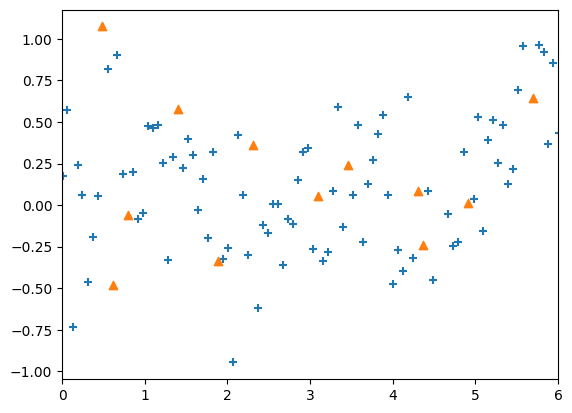

In [138]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Datasets/NASDAQCOM.csv')

df.head(n=10)

,DATE,NASDAQCOM,Decimal_Date
0,1971-02-05,100.00,1971.095890
1,1971-02-08,100.84,1971.104110
2,1971-02-09,100.76,1971.106849
3,1971-02-10,100.69,1971.109589
4,1971-02-11,101.45,1971.112329
5,1971-02-12,102.05,1971.115068
6,1971-02-16,102.19,1971.126027
7,1971-02-17,101.74,1971.128767
8,1971-02-18,101.42,1971.131507
9,1971-02-19,100.70,1971.134247


In [141]:
x = df['Decimal_Date'].to_numpy()
y = df['NASDAQCOM'].to_numpy()

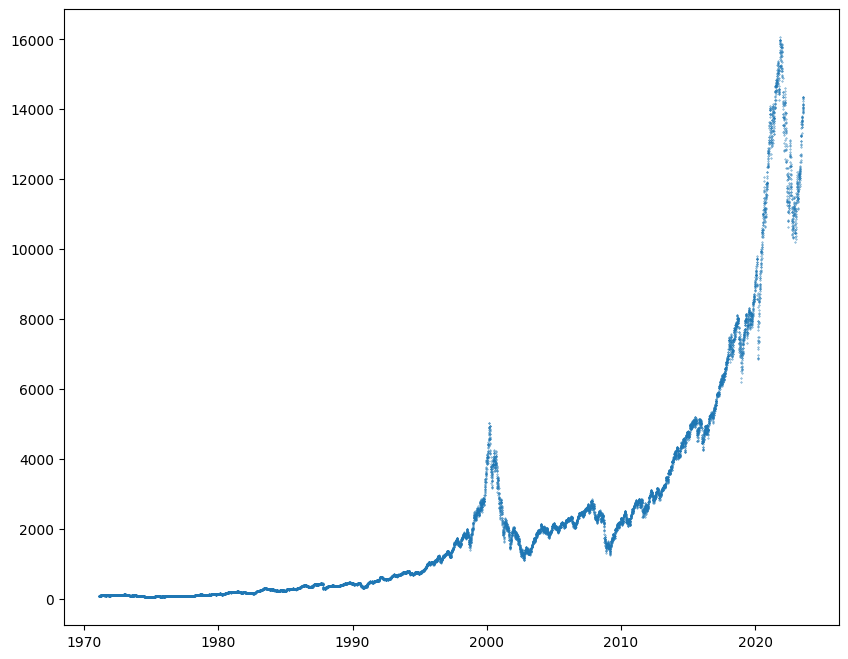

In [157]:
plt.figure(figsize=(10,8))
plt.scatter(x,y, s = 0.1)


In [147]:
df.head()

,DATE,NASDAQCOM,Decimal_Date
0,1971-02-05,100.00,1971.095890
1,1971-02-08,100.84,1971.104110
2,1971-02-09,100.76,1971.106849
3,1971-02-10,100.69,1971.109589
4,1971-02-11,101.45,1971.112329
